In [1]:
import numpy as np
from stochastic.processes.continuous import FractionalBrownianMotion
from scipy.special import gamma
import multiprocessing as mp
import matplotlib.pyplot as plt
import pandas as pd
import time


def GenerateNoise(H, t_fin, t_init, N, alpha, A, rng):
    '''the parameter rng produces unique series of random numbers at each simulation trajectory'''
    fbm = FractionalBrownianMotion(hurst=1-H, t=(t_fin - t_init), rng=rng)
    noise = np.sqrt(2 / gamma(1 + alpha)) / A * fbm.sample(N)
    return noise


def force_term(j, x):
    return x[j-1]


def approxfun(n, alpha, j, x):
    return float(force_term(j,x)*(((n-j+1)**alpha) - ((n-j) ** alpha)))


def simulate_process(args):
    H, t_fin, t_init, N, alpha, A, dt, r, xr, xa, m, w, seed, i = args

    # random number generator with a unique seed
    rng = np.random.default_rng(seed)
    coefficient = (m*(w**2)*(dt**alpha))/(gamma(1+alpha))
    noise = GenerateNoise(H, t_fin, t_init, N, alpha, A, rng)

    x = np.zeros(N)
    xm = 0
    tr = 0
    reset_step = 1
    count = 0
    nn = []

    for n in range(1, N):
        r1 = rng.uniform(0, 1)
        if r1 < r * dt:
            x[n] = xr
            xm = xr
            reset_time = n*dt
            reset_step = n
            noise = GenerateNoise(H, t_fin, t_init+reset_time, N-reset_step, alpha, A, rng)
            count += 1
        else:
            x[n] = xm + x[0] - coefficient*sum(approxfun(n, alpha, j, x) for j in range(reset_step, n+1)) + noise[n-reset_step]

        # stop simulation if the particle hits the absorbing boundary at x = xa
        if x[n] >= xa:
            
            return n*dt
            break

    return n*dt 

if __name__ == "__main__":
    r = 0.3      # reset rate 
    xr = 0.5   # reset position 
    m = 1.0    # mass 
    w = 1.0    # barrier frequency 
    zeta = 1.0      # friction coefficient 
    H = 0.65        # Hurst index 
    N = 100000      # simulation steps 
    nreps = 1000     # number of simulations/trajectories 
    xa = 1          # absorbing boundary 
    t_init = 0.0    # initial time 
    t_fin = 100.0   # final time 
    dt = (t_fin - t_init) / N   # time interval
    print(f'Time interval = {dt} sec.')
    alpha = 2-2*H
    A = 2*zeta*H*(2*H-1)*gamma(1-alpha)
    t1 = time.time()
    
    with mp.Pool(processes=60) as pool:
        # generate unique seeds for each trajectory
        base_seed = int(time.time())
        seeds = [base_seed + i for i in range(nreps)]
        args = [(H, t_fin, t_init, N, alpha, A, dt, r, xr, xa, m, w, seeds[i], i) for i in range(nreps)]
        fpt = pool.map(simulate_process, args)

    time_req = (time.time() - t1)/60
    print(f'Simulation time = {time_req} min')

Time interval = 0.001 sec.
Simulation time = 0.3896909117698669 min


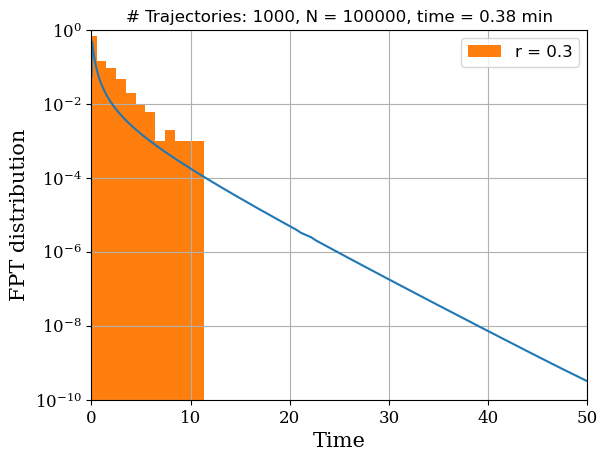

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df1 = pd.read_csv('/home/debasish/Documents/resetting_fpt/S_r0_xr0p5_H0p65.csv', header=None)
df2 = pd.read_csv('/home/debasish/Documents/resetting_fpt/S_r0p3_xr0p5_H0p65.csv', header=None)

time = df1[0].to_list()
s1 = df1[1].to_list()
s2 = df2[1].to_list()

diff_t = np.diff(time)
t_mid = time[:-1] + diff_t / 2

diff_s1 = np.diff(s1)
diff_s2 = np.diff(s2)

fpt1 = -diff_s1/diff_t
fpt2 = -diff_s2/diff_t

plt.plot(t_mid, fpt2)
# plt.plot(time[1:], fpt2)
plt.yscale('log')
plt.ylim(1e-10, 1)
plt.grid(True)


plt.hist(fpt,bins=12,density=True,label=f'r = {r}',align='left')
plt.xlim(0,50)
plt.yscale('log')
plt.legend(fontsize=12)
plt.xlabel('Time', fontsize=15, fontfamily='serif')
plt.ylabel('FPT distribution', fontsize=15, fontfamily='serif')
# plt.savefig('/home/debasish/Documents/Wolfram Mathematica/resetting/simulation/final/fpt_r0p1.png')
# plt.ylim(0,0.01)
plt.title(f'# Trajectories: {nreps}, N = {N}, time = {np.round(time_req,2)} min')
plt.xticks(fontsize=12,fontfamily='serif')
plt.yticks(fontsize=12,fontfamily='serif')
plt.show()